## **Predicción de la vida útil restante (RUL) del motor de turbofán basado en Ciencia de Datos y Aprendizaje Automático (REGRESIÓN LINEAL DE RIDGE).**

En este notebook me enfocaré en el desarrollo del modelo de regresion lineal de Ridge, el EDA y la importancia del estudio fueron desarrollados en el notebook Predicting Remaining Useful Life (RUL). Se realizará:

- CARGAR LOS DATOS CONCATENADOS
- PREPARACION DE DATOS (AÑADIR LA RUL, AÑADIR LAS OPERACIONES POR CONDICIÓN)
- SE REALIZARÁ UN MODELO LINEAL BASE (COMPARAR RESULTADOS).
- SE IMPLEMENTARÁ RIDGE CON AJUSTE DE HYPERPARAMETROS.
- SE VISUALIZARÁN CURVAS DE APRENDIZAJE.
- CONCLUSIONES.


### **DESARROLLO.**

#### **Data Collection (Recolección de datos).**

 Los datos se descargan del repositorio de la NASA en [1] y se almacenan en un formato adecuado (CSV y DataFrame de Pandas), la versión usada fue de mayo del 2023. Actualmente en su ultima versión del 31 marzo del 2025 el dataset ya no es público.

La mayoria de los estudios empiezan con FD001 aplicando diferentes modelos hasta el más desafiante que es FD004 con modelos más complejos. Para este estudio nos centraremos en un modelo generalista, un modelo práctico para un entorno real que funcione en diferentes condiciones operativas (distintas condiciones de fallo, múltiples motores, diferentes regímenes de estrés), es decir concatenaremos los subset de datos, como los subconjuntos provienen de la misma distribución (mismo tipo de motores, mismos sensores, misma metodología de recolección) y solo varían en condiciones operativas, esto puede tener muchas ventajas como  aumentar la diversidad de datos y mejorar la robustez del modelo, ayudar a evitar overfitting y mejorar el entrenamiento de modelos de Machine Learning.

In [2]:
#Librerias importadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve # cruva de aprendizaje
import joblib
import random

SEED=42
random.seed(SEED)
np.random.seed(SEED)


In [3]:
#SEGMENTO DONDE DEFINO FUNCIONES A UTILIZAR

# Esta función evalúa el desempeño de un modelo de regresión.
def evaluate(y_true, y_hat, label='test'):
    """
    Evalúa el desempeño de un modelo de regresión utilizando RMSE y R².

    Parámetros:
    y_true -- valores reales de la variable dependiente (array o lista)
    y_hat -- valores predichos por el modelo (array o lista)
    label -- etiqueta opcional para identificar el conjunto evaluado (por defecto: 'test')
    """

    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)

    print(f'{label} set RMSE: {rmse:.4f}, R²: {variance:.4f}')

# Esta función añade como característica a la variable objetivo.
def add_remaining_useful_life(df):
    """
    Añade la columna RUL (Remaining Useful Life) al dataframe C-MAPSS.

    Parámetros:
    df -- DataFrame con datos de los sensores, que debe incluir las columnas 'unit_nr' y 'time_cycles'

    Retorna:
    Un nuevo DataFrame con una columna adicional llamada 'RUL'
    """

    # Paso 1: Calcular el número máximo de ciclos por cada unidad (motor)
    # Esto representa el ciclo en el que la unidad falló (fin de su vida útil)
    max_cycles_per_unit = df.groupby("unit_nr")["time_cycles"].transform('max')

    # Paso 2: Calcular el Remaining Useful Life restando el ciclo actual al máximo ciclo
    df["RUL"] = max_cycles_per_unit - df["time_cycles"]

    # Retornar el DataFrame modificado con la columna RUL añadida
    return df



In [4]:
def add_operating_conditions(df, alt_col='altitude', mach_col='mach', temp_col='temperature'):
    """
    Añade una columna 'operating_condition_id' al DataFrame en base a las combinaciones únicas
    de altitud, Mach y temperatura (redondeadas para evitar ruido).

    Parámetros:
    - df: DataFrame original con las columnas de altitud, Mach y temperatura.
    - alt_col, mach_col, temp_col: Nombres de las columnas correspondientes.

    Devuelve:
    - El DataFrame original con una nueva columna 'operating_condition_id'.
    - Un DataFrame con las combinaciones únicas de condiciones operativas.
    """
    df_grouped = df.copy()

    # Redondeo para agrupar correctamente condiciones similares
    df_grouped['alt'] = df_grouped[alt_col].round(0)
    df_grouped['Mach'] = df_grouped[mach_col].round(2)
    df_grouped['TRA'] = df_grouped[temp_col].round(1)

    # Crear tupla de condición operativa y asignar códigos únicos
    df_grouped['operating_condition'] = df_grouped[['alt', 'Mach', 'TRA']].apply(tuple, axis=1)
    df_grouped['operating_condition_id'] = df_grouped['operating_condition'].astype('category').cat.codes

    # Asignar la columna al DataFrame original
    df['operating_condition_id'] = df_grouped['operating_condition_id'].astype(int)

    # También retorna las combinaciones únicas y sus conteos por si lo necesitas
    condition_counts = df_grouped.groupby('operating_condition_id').size().reset_index(name='count')
    unique_conditions = df_grouped[['operating_condition_id', 'alt', 'Mach', 'TRA']].drop_duplicates()
    unique_conditions = unique_conditions.merge(condition_counts, on='operating_condition_id')

    return df, unique_conditions

In [5]:
# URL
FD=1
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# definir el nombre de las columnas para fácil adaptación
index_names = ['unit_nr', 'time_cycles']
setting_names = ['altitude', 'mach', 'temperature']
sensor_names = ["t2", "t24", "t30", "t50",
    "p2", "p15", "p30",
    "nf", "nc",
    "epr", "ps30", "phi",
    "nrf", "nrc", "bpr", "farb", "htbleed",
    "nf_dmd", "pcnfr_dmd",
    "w31", "w32"]
col_names = index_names + setting_names + sensor_names

train = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])



In [6]:
# URL
FD=2
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

# leer dataset
train2 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test2 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test2 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])


In [7]:
# URL
FD=3
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

train3 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test3 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test3 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])


In [8]:
# URL
FD=4
url_train=  'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00'+str(FD)+'.txt'
url_test ='https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00'+str(FD)+'.txt'
url_rul = 'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00'+str(FD)+'.txt'

train4 = pd.read_csv((url_train), sep=r'\s+', header=None, names=col_names)
test4 = pd.read_csv((url_test), sep=r'\s+', header=None, names=col_names)
y_test4 = pd.read_csv((url_rul), sep=r'\s+', header=None, names=['RUL'])

In [9]:
# Encontrar el valor máximo de unit_nr en train
max_unit_nr = train["unit_nr"].max()
# Ajustar los valores de unit_nr en train4 sumando el valor máximo de train esto para añadir secuecia en los motores
train2["unit_nr"] += max_unit_nr
max_unit_nr2 = train2["unit_nr"].max()
train3["unit_nr"] += max_unit_nr2
max_unit_nr3 = train3["unit_nr"].max()
train4["unit_nr"] += max_unit_nr3

# Concatenar los DataFrames por filas (axis=0)
train_final = pd.concat([train,train2,train3,train4], axis=0, ignore_index=True)

In [10]:
# Combinar los datos de prueba con las etiquetas RUL
test['RUL'] = y_test['RUL']
test2['RUL'] = y_test2['RUL']
test3['RUL'] = y_test3['RUL']
test4['RUL'] = y_test4['RUL']

# Encontrar el valor máximo de unit_nr en train
max_unit_nr = test["unit_nr"].max()
# Ajustar los valores de unit_nr en train4 sumando el valor máximo de train
test2["unit_nr"] += max_unit_nr
max_unit_nr2 = test2["unit_nr"].max()
test3["unit_nr"] += max_unit_nr2
max_unit_nr3 = test3["unit_nr"].max()
test4["unit_nr"] += max_unit_nr3

test_final = pd.concat([test,test2,test3,test4], axis=0, ignore_index=True)

In [11]:
# Guardar los datos de entrenamiento en un CSV
#train_final.to_csv('cmapps_entrenamiento_concatenado.csv', index=False)

# Guardar los datos de prueba en un CSV
#test_final.to_csv('cmapps_prueba_concatenado.csv', index=False)

#print("Archivos CSV generados con éxito: 'cmapps_entrenamiento_concatenado.csv' y 'cmapps_prueba_concatenado.csv'.")

In [12]:
train=train_final
test=test_final

In [13]:
train[['htbleed', 'nf_dmd']] = train[['htbleed', 'nf_dmd']].astype(float)
test[['htbleed', 'nf_dmd']] = test[['htbleed', 'nf_dmd']].astype(float)

#### **PREPARACIÓN DE DATOS**

Se añade la RUL como característica en el conjunto de datos, así como se añaden las condiciones de operación y se aplica one hot enconding.

In [14]:
train=add_remaining_useful_life(train)

In [15]:
train, unique_conditions = add_operating_conditions(train)
unique_conditions

,operating_condition_id,alt,Mach,TRA,count
0,0,-0.0,-0.00,100.0,62633
1,4,35.0,0.84,100.0,17199
2,5,42.0,0.84,100.0,28853
3,3,25.0,0.62,60.0,17141
4,2,20.0,0.70,100.0,17213
5,1,10.0,0.25,100.0,17320


Se podría dar una descripción a los siguientes modos de operación


| operating_condition_id | alt (Altitud) | Mach | Temp(°F)  | Descripción                                      |
|------------------------|---------------|------|------|--------------------------------------------------|
| 0                      | 0.0           | 0.00 | 100.0| Arranque/estático                                |
| 1                      | 10.0          | 0.25 | 100.0| Vuelo bajo lento, acelerador al 100%             |
| 2                      | 20.0          | 0.70 | 100.0| Vuelo medio, crucero rápido                      |
| 3                      | 25.0          | 0.62 | 60.0 | Vuelo medio con menor potencia                   |
| 4                      | 35.0          | 0.84 | 100.0| Vuelo alto, máxima velocidad                     |
| 5                      | 42.0          | 0.84 | 100.0| Vuelo más alto, misma velocidad (redundancia deliberada) |


Los valores de alt, mach y temp se agrupan claramente en combinaciones discretas, lo que da lugar a las 6 condiciones operativas que ya se identificaron. Aunque parecen variables continuas, en realidad funcionan como features categóricas encubiertas. La ventaja de tratar esta columna como una variable categórica es que, a diferencia de una variable numérica, las categorías no tienen un orden implícito, pero permiten al modelo identificar patrones específicos relacionados con cada combinación de las características (altitud, Mach, temperatura) sin tener que tratarlas como valores numéricos continuos.

operating_condition_id
0    62633
5    28853
1    17320
2    17213
4    17199
3    17141
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribución de condiciones operativas en el conjunto de entrenamiento')

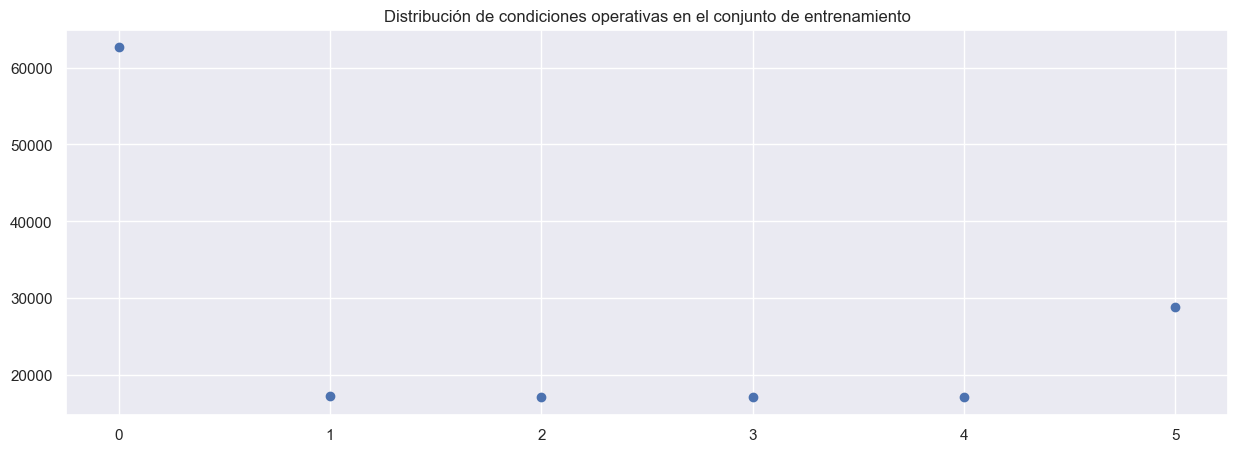

In [16]:
print(train['operating_condition_id'].value_counts())

plt.figure(figsize=(15,5))
plt.plot(train['operating_condition_id'].value_counts(), 'o')
plt.title('Distribución de condiciones operativas en el conjunto de entrenamiento')

In [17]:
X_train = train
y_train = X_train.pop('RUL')

In [18]:
test,unique_test=add_operating_conditions(test) 

In [19]:
test

,unit_nr,time_cycles,altitude,mach,temperature,t2,t24,t30,t50,p2,...,nrc,bpr,farb,htbleed,nf_dmd,pcnfr_dmd,w31,w32,RUL,operating_condition_id
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,112.0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,98.0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,69.0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,82.0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,91.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104892,707,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,8112.61,9.4427,0.02,331.0,2212.0,100.0,10.53,6.2620,NaN,5
104893,707,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,8086.83,9.2772,0.02,366.0,2324.0,100.0,24.33,14.6486,NaN,2
104894,707,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,8100.84,9.3982,0.02,336.0,2223.0,100.0,14.69,8.8389,NaN,4
104895,707,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,8085.24,9.2727,0.03,366.0,2324.0,100.0,24.44,14.6887,NaN,2


In [20]:
# Dado que los valores RUL reales del conjunto de prueba solo se proporcionan para el último ciclo de cada motor, el conjunto de prueba se subdivide para representar lo mismo.
y_test = test.pop('RUL') 
y_test = y_test[y_test.notna()].reset_index(drop=True)
X_test = test.groupby('unit_nr').last().reset_index()

In [21]:
# One hot enconding dropeo el primero para evitar multicolinealidad en modelos lineales.
X_train_encoded = pd.get_dummies(X_train, columns=['operating_condition_id'],drop_first=True).drop(columns=index_names+setting_names,axis=1)
X_test_encoded = pd.get_dummies(X_test, columns=['operating_condition_id'],drop_first=True).drop(columns=index_names+setting_names,axis=1)

In [23]:
X_train_encoded=X_train_encoded.astype(float)
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   t2                        160359 non-null  float64
 1   t24                       160359 non-null  float64
 2   t30                       160359 non-null  float64
 3   t50                       160359 non-null  float64
 4   p2                        160359 non-null  float64
 5   p15                       160359 non-null  float64
 6   p30                       160359 non-null  float64
 7   nf                        160359 non-null  float64
 8   nc                        160359 non-null  float64
 9   epr                       160359 non-null  float64
 10  ps30                      160359 non-null  float64
 11  phi                       160359 non-null  float64
 12  nrf                       160359 non-null  float64
 13  nrc                       160359 non-null  f

### **SELECCIóN DEL MODELO.**

#### Modeling (Modelado) Lineal Base

El modelo base ahora usamos todos los sensores, más las dummies de la condición de operación.

In [81]:
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
# create and fit model
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train_scaled)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE: 55.4796, R²: 0.5589
test set RMSE: 43.5085, R²: 0.2743


Calcular las métricas de evaluación del conjunto de entrenamiento es conocida como una evaluación in-training y se refiere a medir el rendimiento del modelo sobre los mismos datos que se usaron para entrenarlo. Esto no busca evaluar la generalización, sino entender cómo el modelo está aprendiendo durante el entrenamiento.

Ahora observamos una mejora un poco del modelo base con respecto al anterior esto indica que trabajar con mas características originales sin dropear alguna, ayuda en algo al modelo, en fin esto lo confirmaremos con la optimización de hiperparámetros en Ridge.

modelo base 1
test set RMSE: 44.0242, R²: 0.2570

modelo base 2
test set RMSE: 43.5085, R²: 0.2743

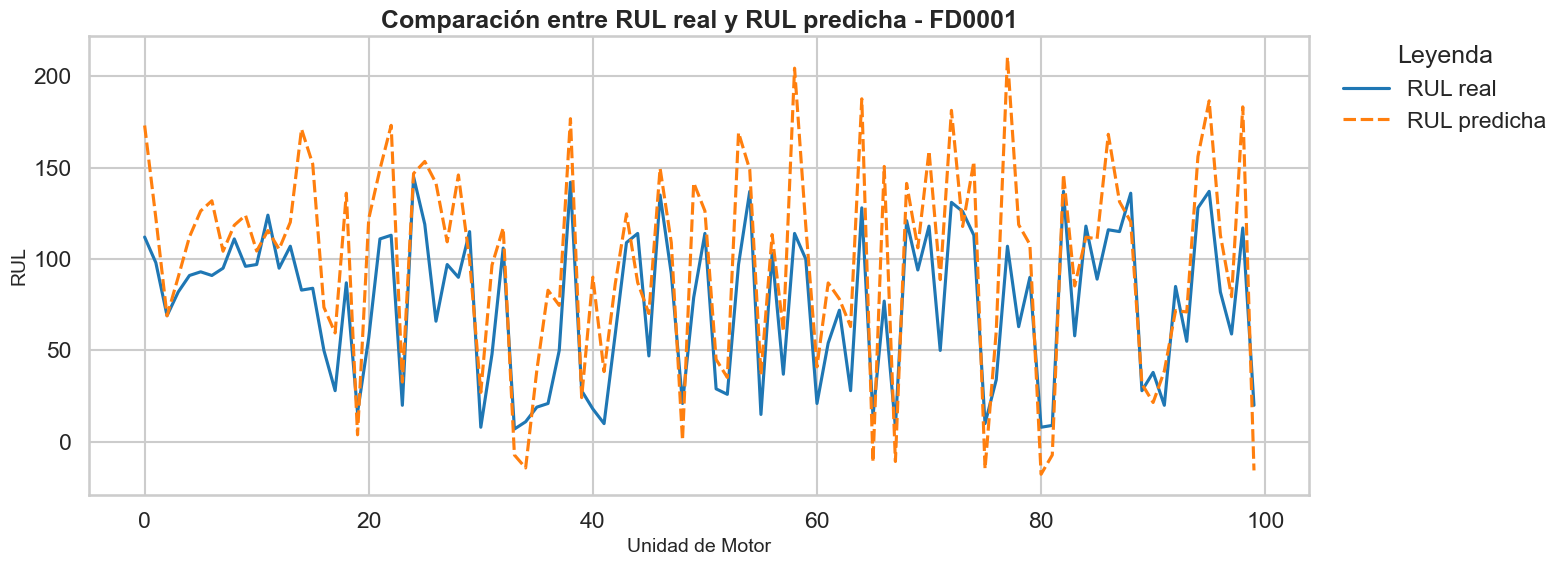

In [82]:
# Estilo de Seaborn
plt.style.use('seaborn-v0_8-whitegrid')
# Estilo de Seaborn
sns.set(style="whitegrid", context="talk")

# Crear DataFrame con resultados
df_resultados = pd.DataFrame({
    'RUL real': y_test[:100],
    'RUL predicha': y_hat_test[:100]
})

# Crear DataFrame con resultados
df_resultados = pd.DataFrame({
    'RUL real': y_test[:100],
    'RUL predicha': y_hat_test[:100]
})

# Gráfico más ancho
plt.figure(figsize=(16, 6))

# Graficar las dos líneas
sns.lineplot(data=df_resultados, palette=['#1f77b4', '#ff7f0e'])

# Título y etiquetas
plt.title('Comparación entre RUL real y RUL predicha - FD0001', fontsize=18, weight='bold')
plt.xlabel('Unidad de Motor', fontsize=14)
plt.ylabel('RUL', fontsize=14)

# Leyenda fuera del área del gráfico
plt.legend(title='Leyenda', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

#### **REGRESIÓN LINEAL DE RIDGE.**

Porque Ridge, conocemos por el EDA que la relación entre las características y la variable objetivo es no lineal o compleja, sin embargo Ridge es mejor si todas las variables pueden ser relevantes (como lo mostramos anteriormente). Ridge reduce los coeficientes de manera más equilibrada, manteniendo la contribución de todas las variables (aunque con pesos pequeños en ciertos casos) y sobre todo suele tener menor varianza en sus estimaciones.

Ahora la idea con Rigde es confirmar que el modelo mejora con más características originales del dataset y probar con el preprocesamiento de los datos como escalado por condición y One Hot Enconding.

Por ende hacemos primero feature selección, luego featuring engenering con polinomal features y finalizamos escalando los datos de formma general.

In [83]:
# Lista de valores para k
k_values = [14, 21, 26]

# Definir el pipeline para Ridge
ridge_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_regression)),
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()), # Estandar Escaler Global
    ('model', Ridge())
])

# Definir espacio de búsqueda
param_grid_ridge = {
    'feature_selection__k': k_values,       
    'model__alpha': [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1,10,100,1e3]
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

In [ ]:
# Optimización con GridSearchCV para Ridge
grid_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf,verbose=4)
grid_ridge.fit(X_train_encoded, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[CV 1/10] END feature_selection__k=14, model__alpha=1e-07; neg_root_mean_squared_error: (train=-53.906, test=-53.669) r2: (train=0.584, test=0.586) total time= 1.1min
[CV 2/10] END feature_selection__k=14, model__alpha=1e-07; neg_root_mean_squared_error: (train=-53.801, test=-54.090) r2: (train=0.585, test=0.581) total time=  43.2s
[CV 3/10] END feature_selection__k=14, model__alpha=1e-07; neg_root_mean_squared_error: (train=-53.910, test=-53.651) r2: (train=0.584, test=0.584) total time=  42.7s
[CV 4/10] END feature_selection__k=14, model__alpha=1e-07; neg_root_mean_squared_error: (train=-53.806, test=-54.075) r2: (train=0.585, test=0.583) total time=  42.9s
[CV 5/10] END feature_selection__k=14, model__alpha=1e-07; neg_root_mean_squared_error: (train=-53.828, test=-53.986) r2: (train=0.584, test=0.585) total time=  44.0s
[CV 6/10] END feature_selection__k=14, model__alpha=1e-07; neg_root_mean_squared_error: (train=-53.877

In [ ]:
best_ridge = grid_ridge.best_estimator_

# Comparación de resultados
ridge_rmse = -grid_ridge.best_score_
print(f"Mejor RMSE Ridge: {ridge_rmse:.4f}, Mejor configuración: {grid_ridge.best_params_}")


Mejor RMSE Ridge: 51.5663, Mejor configuración: {'feature_selection__k': 26, 'model__alpha': 1e-07}


In [ ]:
# Guardar grid_ridge
#joblib.dump(grid_ridge, 'grid_ridge_full2.pkl')

# Guardar best_ridge
#joblib.dump(best_ridge, 'ridge_best_model2.pkl')

#print("Modelos guardados exitosamente: 'grid_ridge_full.pkl' y 'ridge_best_model.pkl'.")

Modelos guardados exitosamente: 'grid_ridge_full.pkl' y 'ridge_best_model.pkl'.


In [ ]:
# Cargar el GridSearchCV completo (incluye CV results, etc.)
#grid_ridge = joblib.load('grid_ridge_full2.pkl')

# Cargar el mejor modelo (best_estimator_)
#best_ridge = joblib.load('ridge_best_model2.pkl')

# Confirmar que se cargaron correctamente
#print("Modelos cargados exitosamente.")

Modelos cargados exitosamente.


In [ ]:
# Hacer predicciones con el mejor modelo
y_hat_trainreg = best_ridge.predict(X_train_encoded)
y_hat_testreg = best_ridge.predict(X_test_encoded)

# Evaluar el rendimiento del modelo en el conjunto de prueba
evaluate(y_train, y_hat_trainreg, 'train')
evaluate(y_test, y_hat_testreg)

train set RMSE: 51.4932, R²: 0.6200
test set RMSE: 39.5969, R²: 0.3989


En base a los resultados, el modelo optimizado no está sobreajustando gravemente (porque el RMSE de test no es peor que el de entrenamiento), pero tampoco está generalizando bien (por el bajo R² en test). Esto sugiere que:
-	El modelo no captura completamente la complejidad del problema.
-	Se podría explorar una arquitectura más potente o aumentar la cantidad de datos.
-	También puede ser útil hacer una mejor selección de características o incorporar más ingeniería de variables, pero para este modelo no se lo realizará.
- Me quedo con que el modelo mejoró con más características, asi que la idea de dropear o eliminar sensores del dataset original porque son constantes o su relación con la variable objetivo es baja no tiene mucho sentido. 


### **Tabla 1. Comparación de modelos.**

| Métrica       | Modelo Base dropsensors (A) | Modelo Base completo + dummies (B) | Modelo Ajustado Ridge + dummies (C) | A vs B               | B vs C               | A vs C               |
|---------------|----------------------------|--------------------------|---------------------|----------------------|----------------------|----------------------|
| **RMSE**      | 44.0242                    | 43.5085                  | **39.5969**         | ↑ 0.5157 (1.17%)     | ↓ 3.9116 (8.99%)     | ↓ 4.4273 (10.06%)    |
| **R²**        | 0.2570                     | 0.2743                   | **0.3989**          | ↓ 0.0173 (6.31%)     | ↑ 0.1246 (45.42%)    | ↑ 0.1419 (55.21%)    |


#### **CURVAS DE APRENDIZAJE.**

In [ ]:
# Obtener los resultados de la búsqueda de parámetros
results = grid_ridge.cv_results_

train_errors = -results['mean_train_neg_root_mean_squared_error']
val_errors = -results['mean_test_neg_root_mean_squared_error']

# Obtener los valores de alpha probados
alphas = param_grid_ridge['model__alpha']

print("Dimensiones de alphas:", len(alphas))
print("Dimensiones de train_errors:", len(train_errors))
print("Dimensiones de val_errors:", len(val_errors))

Dimensiones de alphas: 9
Dimensiones de train_errors: 27
Dimensiones de val_errors: 27


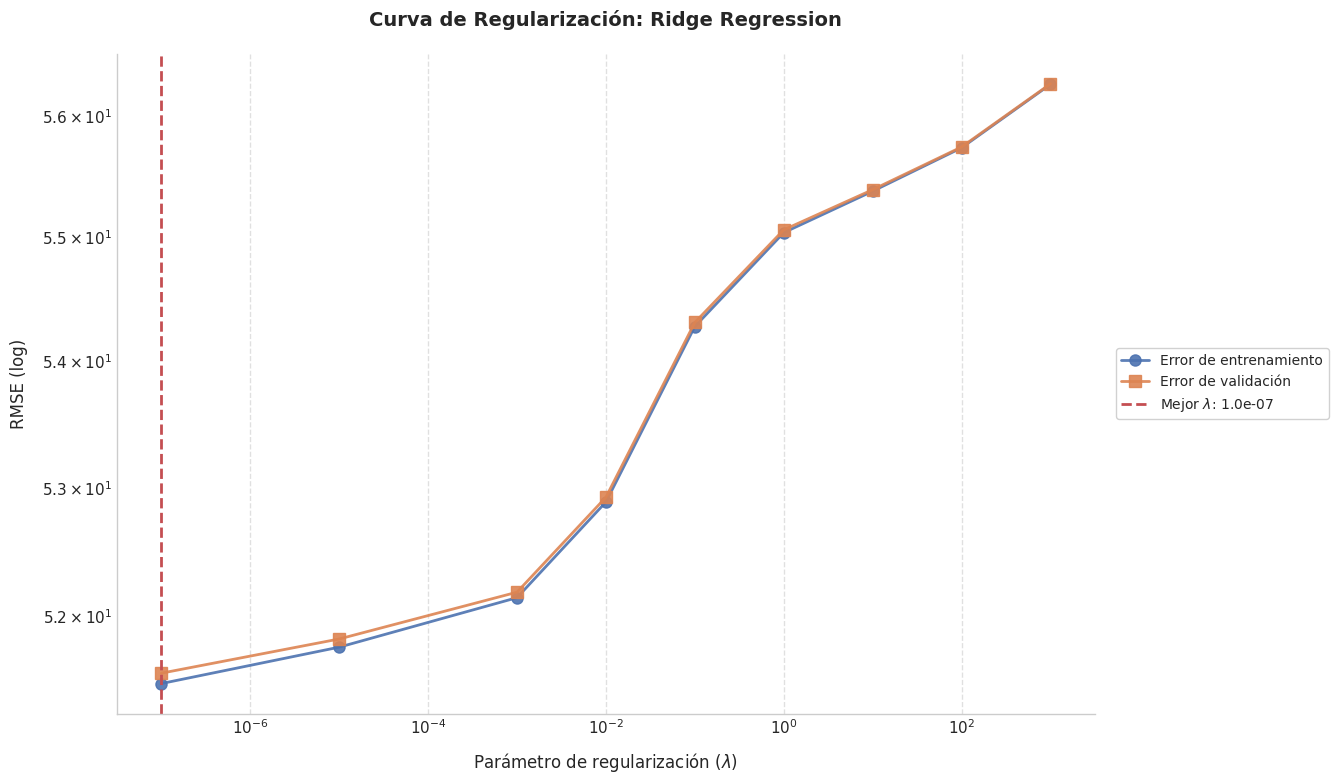

In [ ]:
# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'

# Crear figura con espacio adicional para la leyenda
fig, ax = plt.subplots(figsize=(16, 8), dpi=100)
fig.subplots_adjust(right=0.90)  # Deja 25% de espacio a la derecha

# Graficar errores (ajusta los índices según tus datos)
ax.plot(alphas, train_errors[18:27], 
        label='Error de entrenamiento', 
        marker='o', markersize=8, 
        color='#4C72B0', linewidth=2, alpha=0.9)

ax.plot(alphas, val_errors[18:27], 
        label='Error de validación', 
        marker='s', markersize=8,
        color='#DD8452', linewidth=2, alpha=0.9)

# Línea del mejor alpha
best_alpha = best_ridge.named_steps['model'].alpha
ax.axvline(x=best_alpha, color='#C44E52', linestyle='--', linewidth=2,
           label=fr'Mejor $\lambda$: {best_alpha:.1e}')

# Escalas y ejes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Parámetro de regularización ($\lambda$)', fontsize=12, labelpad=10)
ax.set_ylabel('RMSE (log)', fontsize=12, labelpad=10)
ax.set_title('Curva de Regularización: Ridge Regression', 
             fontsize=14, pad=20, weight='bold')

# Grid y leyenda FUERA del gráfico
ax.grid(True, linestyle='--', alpha=0.6)
legend = ax.legend(
    frameon=True,
    framealpha=0.9,
    loc='center left',          # Posición centrada a la izquierda
    bbox_to_anchor=(1.02, 0.5),  # Desplazada a la derecha (1.02) y centrada en y (0.5)
    fontsize=10,
    borderaxespad=0.1           # Espacio entre leyenda y ejes
)

# Ajustes finales
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajusta el área útil (85% del ancho)
plt.show()

#### **Curva de aprendizaje por Datos.**

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    best_ridge, X_train_encoded, y_train, cv=rkf, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

In [ ]:
train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

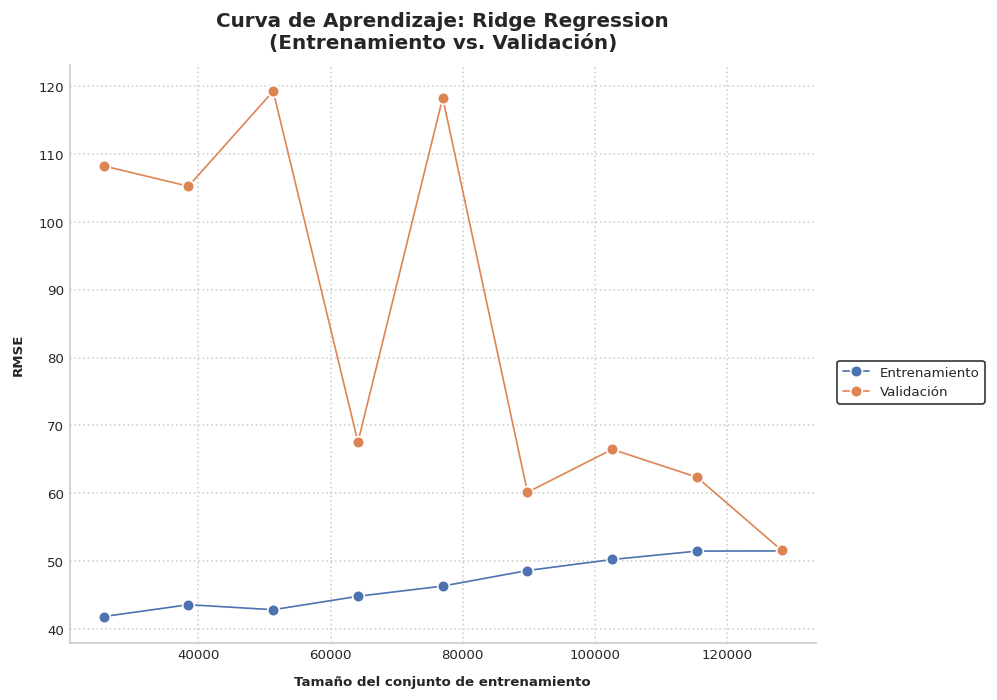

In [ ]:
# Configuración de estilo (inspirada en Claus Wilke)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'  # Fuente sin serifa para legibilidad
plt.rcParams['axes.facecolor'] = 'white'     # Fondo blanco

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

# Personalización de colores (paleta accesible)
train_color = '#4C72B0'  # Azul
val_color = '#DD8452'    # Rojo

# Graficar curvas con marcadores diferenciados
ax.plot(train_sizes[1:10], train_rmse[1:10], 
        label='Entrenamiento', 
        marker='o', markersize=7, 
        color=train_color, linewidth=1,
        markeredgecolor='white', markeredgewidth=1)

ax.plot(train_sizes[1:10], val_rmse[1:10], 
        label='Validación', 
        marker='o', markersize=7,
        color=val_color, linewidth=1,
        markeredgecolor='white', markeredgewidth=1)

# Títulos y ejes.
ax.set_xlabel('Tamaño del conjunto de entrenamiento', 
              fontsize=8, labelpad=8, weight='semibold')
ax.set_ylabel('RMSE', fontsize=8, labelpad=8, weight='semibold')
ax.set_title('Curva de Aprendizaje: Ridge Regression\n(Entrenamiento vs. Validación)',
             fontsize=12, pad=10, weight='semibold')

# Grid y leyenda
ax.grid(True, linestyle=':', alpha=0.9)  # Grid punteado sutil
legend = ax.legend(frameon=True, framealpha=0.95, 
                   edgecolor='#2A2A2A', fontsize=8,
                   bbox_to_anchor=(1.02, 0.5),  # Leyenda externa derecha
                   loc='upper left')

# Ajustes finales
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Espacio para leyenda externa

plt.show()

#### **Curva REAL vs PREDICHA.**

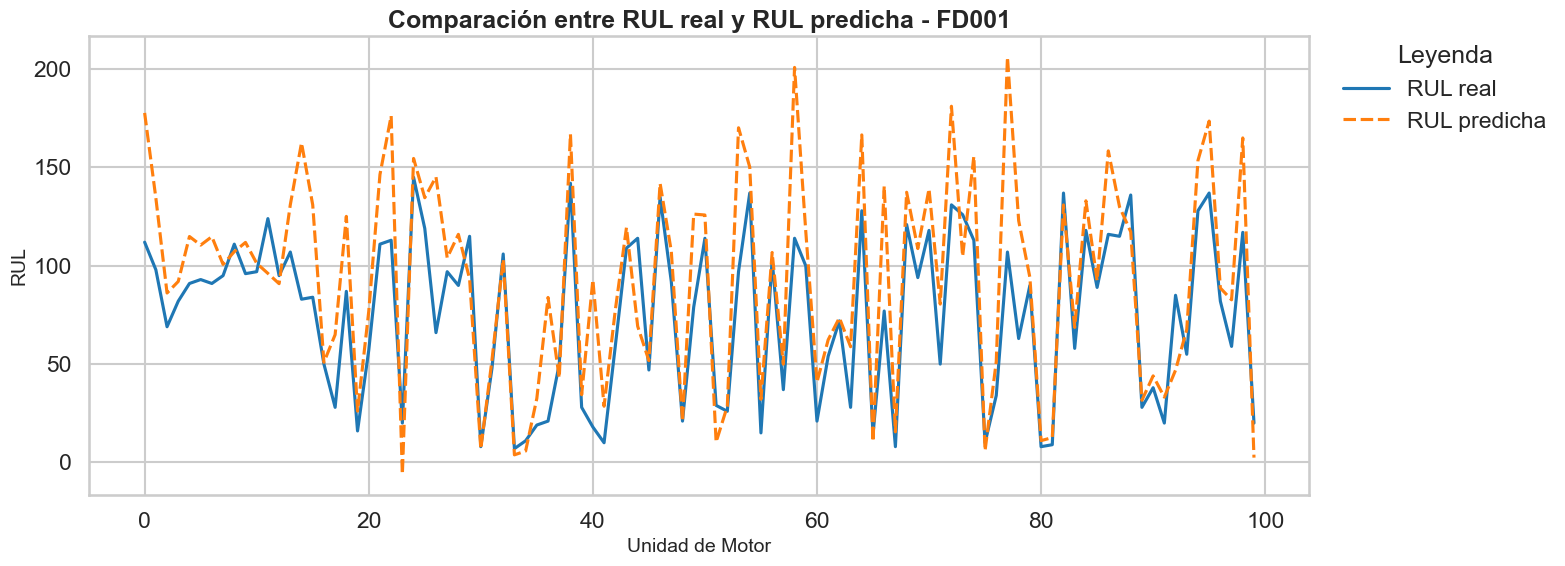

In [ ]:
# Estilo de Seaborn
plt.style.use('seaborn-v0_8-whitegrid')
# Estilo de Seaborn
sns.set(style="whitegrid", context="talk")

# Crear DataFrame con resultados
df_resultados = pd.DataFrame({
    'RUL real': y_test[:100],
    'RUL predicha': y_hat_testreg[:100]
})

# Gráfico más ancho
plt.figure(figsize=(16, 6))

# Graficar las dos líneas
sns.lineplot(data=df_resultados, palette=['#1f77b4', '#ff7f0e'])

# Título y etiquetas
plt.title('Comparación entre RUL real y RUL predicha - FD001', fontsize=18, weight='bold')
plt.xlabel('Unidad de Motor', fontsize=14)
plt.ylabel('RUL', fontsize=14)

# Leyenda fuera del área del gráfico
plt.legend(title='Leyenda', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

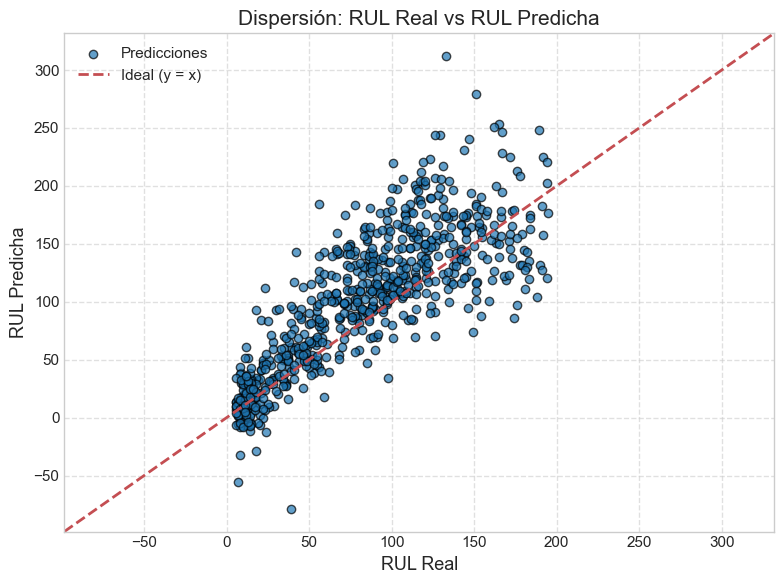

In [ ]:
# Estilo limpio
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Calcular límites con margen (5% extra)
buffer = 0.05
y_min = min(min(y_test), min(y_hat_testreg))
y_max = max(max(y_test), max(y_hat_testreg))
range_padding = (y_max - y_min) * buffer
lower = y_min - range_padding
upper = y_max + range_padding

# Scatter plot
ax.scatter(y_test, y_hat_testreg, alpha=0.7, color='#1f77b4', edgecolor='black', label='Predicciones')

# Línea ideal
ax.plot([lower, upper], [lower, upper], 'r--', linewidth=2, label='Ideal (y = x)')

# Etiquetas y título con tipografía clara
ax.set_xlabel("RUL Real", fontsize=13)
ax.set_ylabel("RUL Predicha", fontsize=13)
ax.set_title("Dispersión: RUL Real vs RUL Predicha", fontsize=15)

# Límites definidos con margen
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

# Cuadrícula ligera
ax.grid(True, linestyle='--', alpha=0.6)

# Leyenda clara
ax.legend(frameon=False, fontsize=11)

# Mejor uso del espacio
plt.tight_layout()
plt.show()


### **Escalar por condición de operación.**

Me interesa el modelo escalado por condición de operación, pese  a que el modelo ya generaliza, en la medida de lo que puede.

In [25]:
sensor_names = sensor_names
condition_column = 'operating_condition_id'
group_column = 'unit_nr'

In [26]:
# ------------------------------
# ConditionScaler personalizado
# ------------------------------
class ConditionScaler(BaseEstimator, TransformerMixin):
    def __init__(self, feature_columns, condition_column='operating_condition_id'):
        self.feature_columns = feature_columns
        self.condition_column = condition_column
        self.scalers_dict_ = {}
        
    def fit(self, X, y=None):
        X = X.astype({col: 'float64' for col in self.feature_columns})
        for condition in X[self.condition_column].unique():
            scaler = StandardScaler()
            scaler.fit(X.loc[X[self.condition_column] == condition, self.feature_columns])
            self.scalers_dict_[condition] = scaler
        return self
        
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.feature_columns] = X_scaled[self.feature_columns].astype('float64')
        for condition, scaler in self.scalers_dict_.items():
            mask = X[self.condition_column] == condition
            X_scaled.loc[mask, self.feature_columns] = scaler.transform(X.loc[mask, self.feature_columns])
        return X_scaled

In [27]:
onehot_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), [condition_column]),
], remainder='passthrough',
    force_int_remainder_cols=False)

In [28]:
X_train[sensor_names+['operating_condition_id']] # solo sensores y condicion de operación

,t2,t24,t30,t50,p2,p15,p30,nf,nc,epr,...,nrf,nrc,bpr,farb,htbleed,nf_dmd,pcnfr_dmd,w31,w32,operating_condition_id
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.30,...,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190,0
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.30,...,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236,0
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.30,...,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442,0
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.30,...,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739,0
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.30,...,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,489.05,605.33,1516.36,1315.28,10.52,15.46,404.59,2319.66,8840.16,1.27,...,2388.73,8185.69,8.4541,0.03,372.0,2319.0,100.0,29.11,17.5234,1
160355,518.67,643.42,1598.92,1426.77,14.62,21.57,567.59,2388.47,9117.12,1.31,...,2388.46,8185.47,8.2221,0.03,396.0,2388.0,100.0,39.38,23.7151,0
160356,518.67,643.68,1607.72,1430.56,14.62,21.57,569.04,2388.51,9126.53,1.31,...,2388.48,8193.94,8.2525,0.03,395.0,2388.0,100.0,39.78,23.8270,0
160357,449.44,555.77,1381.29,1148.18,5.48,7.96,199.93,2223.78,8403.64,1.05,...,2388.83,8125.64,9.0515,0.02,337.0,2223.0,100.0,15.26,9.0774,4


In [29]:
# Definir el pipeline para Ridge
ridge_pipeline2 = Pipeline([
    ('condition_scaler', ConditionScaler(feature_columns=sensor_names, condition_column=condition_column)), # condición de operación
    ('onehot_encoder', onehot_transformer),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge())
])

# Definir espacio de búsqueda
param_grid_ridge2 = {
    'model__alpha': [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1,10,100,1e3]
}

# Validación cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)

In [ ]:
# Optimización con GridSearchCV para Ridge 11 min
grid_ridge2 = GridSearchCV(ridge_pipeline2, param_grid_ridge2, scoring=['neg_root_mean_squared_error','r2'],refit='neg_root_mean_squared_error', return_train_score=True, cv=rkf,verbose=4)
grid_ridge2.fit(X_train[sensor_names+['operating_condition_id']], y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END model__alpha=1e-07; neg_root_mean_squared_error: (train=-51.468, test=-51.287) r2: (train=0.621, test=0.622) total time=   5.0s
[CV 2/10] END model__alpha=1e-07; neg_root_mean_squared_error: (train=-51.386, test=-51.605) r2: (train=0.622, test=0.619) total time=   2.7s
[CV 3/10] END model__alpha=1e-07; neg_root_mean_squared_error: (train=-51.483, test=-51.219) r2: (train=0.621, test=0.621) total time=   2.1s
[CV 4/10] END model__alpha=1e-07; neg_root_mean_squared_error: (train=-51.356, test=-51.728) r2: (train=0.622, test=0.618) total time=   2.7s
[CV 5/10] END model__alpha=1e-07; neg_root_mean_squared_error: (train=-51.363, test=-51.709) r2: (train=0.621, test=0.619) total time=   3.3s
[CV 6/10] END model__alpha=1e-07; neg_root_mean_squared_error: (train=-51.440, test=-51.397) r2: (train=0.620, test=0.624) total time=   2.7s
[CV 7/10] END model__alpha=1e-07; neg_root_mean_squared_error: (train=-51.467, test=-51

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('condition_scaler',
                                        ConditionScaler(feature_columns=['t2',
                                                                         't24',
                                                                         't30',
                                                                         't50',
                                                                         'p2',
                                                                         'p15',
                                                                         'p30',
                                                                         'nf',
                                                                         'nc',
                                                                         'epr',
                                                                         'ps30',
                                                                         'phi',
                                                                         'nrf',
                                                                         'nrc',
                                                                         'bpr',
                                                                         'farb',
                                                                         'htbleed',
                                                                         'nf_dmd',
                                                                         'pcnfr_dmd',
                                                                         'w31',
                                                                         'w32'])),
                                       ('onehot_encoder',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['operating_condition_id'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [1e-07, 1e-05, 0.001, 0.01, 0.1, 1, 10,
                                          100, 1000.0]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=4)

In [ ]:
# Guardar grid_ridge
#joblib.dump(grid_ridge2, 'grid_ridge2.pkl')

#print("Modelos guardados exitosamente: 'grid_ridge2.pkl'.")

Modelos guardados exitosamente: 'grid_ridge2.pkl'.


In [32]:
# Cargar el GridSearchCV completo (incluye CV results, etc.)
#grid_ridge2 = joblib.load('grid_ridge2.pkl')

# Confirmar que se cargaron correctamente
#print("Modelos cargados exitosamente.")

In [33]:
best_ridge2 = grid_ridge2.best_estimator_

# Comparación de resultados
ridge_rmse = -grid_ridge2.best_score_
print(f"Mejor RMSE Ridge: {ridge_rmse:.4f}, Mejor configuración: {grid_ridge2.best_params_}")

Mejor RMSE Ridge: 51.5092, Mejor configuración: {'model__alpha': 100}


In [34]:
# Hacer predicciones con el mejor modelo
y_hat_trainreg = best_ridge2.predict(X_train[sensor_names+['operating_condition_id']])
y_hat_testreg = best_ridge2.predict(X_test[sensor_names+['operating_condition_id']])

# Evaluar el rendimiento del modelo en el conjunto de prueba
evaluate(y_train, y_hat_trainreg, 'train')
evaluate(y_test, y_hat_testreg)

train set RMSE: 51.4213, R²: 0.6211
test set RMSE: 39.3696, R²: 0.4058


**Tabla 2. Comparación de diferentes modelos hasta ahora.** 

| Métrica       | Modelo Base dropsensors General | Modelo Base completo + Dummies | Ridge Estándar Optimizado + Dummies | Ridge + Dummies + ConditionScaler |
|---------------|---------------------|---------------------|----------------|-------------------------|
| **RMSE Train**| 55.7095             | 55.4796             | 51.4932        | 51.4213                 |
| **R² Train**  | 0.5553              | 0.5589              | 0.6200         | 0.6211                  |
| **RMSE Test** | **44.0242**             | **43.5085**             | **39.5969**        | **39.3696**             |
| **R² Test**   | 0.2570              | 0.2743              | 0.3989         | 0.4058              |

- Aunque la mejora es pequeña, es consistente en ambas métricas, indicando que el escalado condicional ayuda a generalizar mejor.
- Los modelos Ridge estan con un ligero overfitting, ConditionScaler no reduce significativamente el overfitting, pero mantiene un equilibrio similar al Ridge estándar.
- El ConditionScaler aporta una mejora sutil pero valiosa en generalización, especialmente útil en entornos donde las condiciones operativas son críticas, como en el problema de la prognósis.

In [35]:
# Obtener los resultados de la búsqueda de parámetros
results = grid_ridge2.cv_results_

train_errors = -results['mean_train_neg_root_mean_squared_error']
val_errors = -results['mean_test_neg_root_mean_squared_error']

# Obtener los valores de alpha probados
alphas = param_grid_ridge2['model__alpha']

print("Dimensiones de alphas:", len(alphas))
print("Dimensiones de train_errors:", len(train_errors))
print("Dimensiones de val_errors:", len(val_errors))

Dimensiones de alphas: 9
Dimensiones de train_errors: 9
Dimensiones de val_errors: 9


In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    best_ridge2, X_train[sensor_names+['operating_condition_id']], y_train, cv=rkf, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)


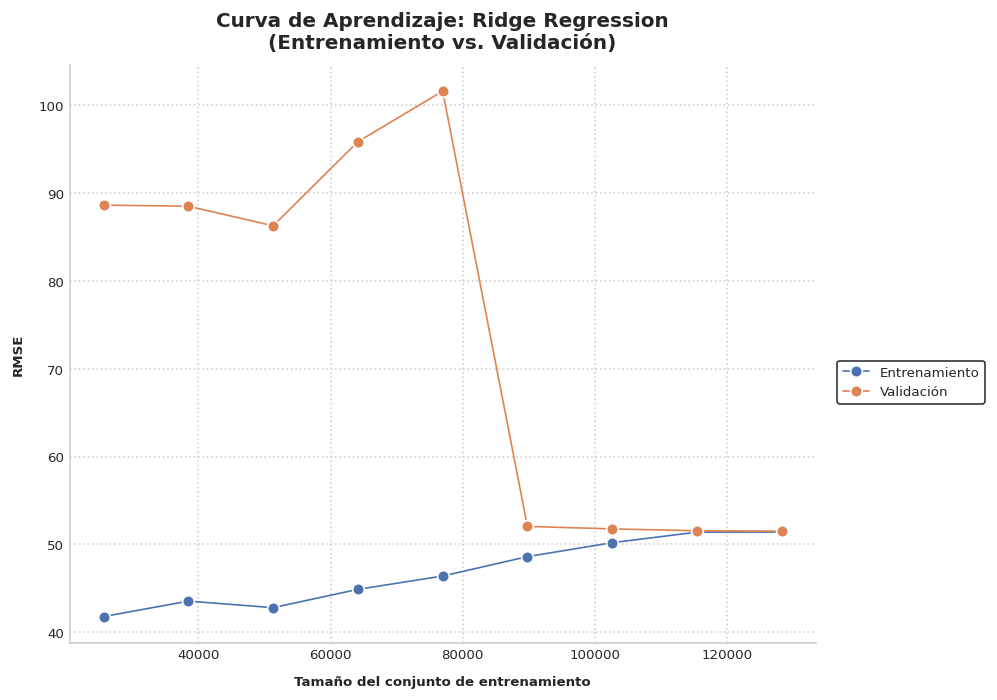

In [37]:
# Configuración de estilo (inspirada en Claus Wilke)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'  # Fuente sin serifa para legibilidad
plt.rcParams['axes.facecolor'] = 'white'     # Fondo blanco

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

# Personalización de colores (paleta accesible)
train_color = '#4C72B0'  # Azul
val_color = '#DD8452'    # Rojo

# Graficar curvas con marcadores diferenciados
ax.plot(train_sizes[1:10], train_rmse[1:10], 
        label='Entrenamiento', 
        marker='o', markersize=7, 
        color=train_color, linewidth=1,
        markeredgecolor='white', markeredgewidth=1)

ax.plot(train_sizes[1:10], val_rmse[1:10], 
        label='Validación', 
        marker='o', markersize=7,
        color=val_color, linewidth=1,
        markeredgecolor='white', markeredgewidth=1)

# Títulos y ejes.
ax.set_xlabel('Tamaño del conjunto de entrenamiento', 
              fontsize=8, labelpad=8, weight='semibold')
ax.set_ylabel('RMSE', fontsize=8, labelpad=8, weight='semibold')
ax.set_title('Curva de Aprendizaje: Ridge Regression\n(Entrenamiento vs. Validación)',
             fontsize=12, pad=10, weight='semibold')

# Grid y leyenda
ax.grid(True, linestyle=':', alpha=0.9)  # Grid punteado sutil
legend = ax.legend(frameon=True, framealpha=0.95, 
                   edgecolor='#2A2A2A', fontsize=8,
                   bbox_to_anchor=(1.02, 0.5),  # Leyenda externa derecha
                   loc='upper left')

# Ajustes finales
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Espacio para leyenda externa

plt.show()

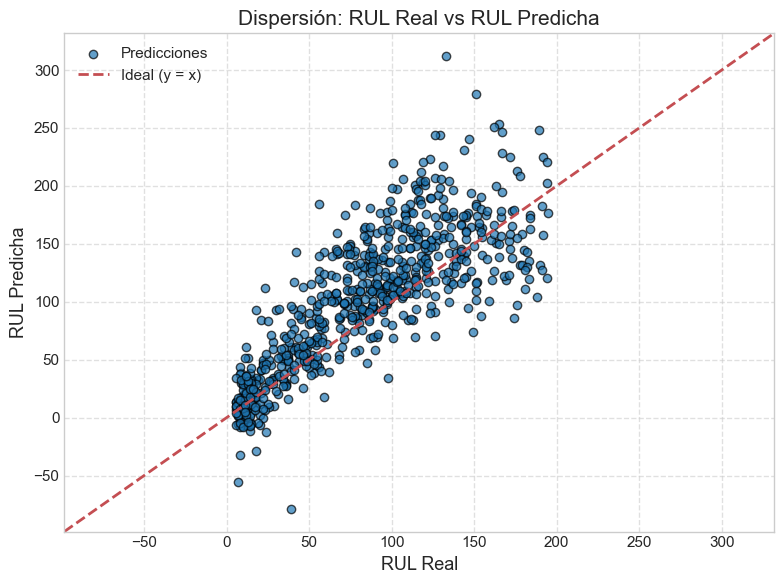

In [38]:
# Estilo limpio
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Calcular límites con margen (5% extra)
buffer = 0.05
y_min = min(min(y_test), min(y_hat_testreg))
y_max = max(max(y_test), max(y_hat_testreg))
range_padding = (y_max - y_min) * buffer
lower = y_min - range_padding
upper = y_max + range_padding

# Scatter plot
ax.scatter(y_test, y_hat_testreg, alpha=0.7, color='#1f77b4', edgecolor='black', label='Predicciones')

# Línea ideal
ax.plot([lower, upper], [lower, upper], 'r--', linewidth=2, label='Ideal (y = x)')

# Etiquetas y título con tipografía clara
ax.set_xlabel("RUL Real", fontsize=13)
ax.set_ylabel("RUL Predicha", fontsize=13)
ax.set_title("Dispersión: RUL Real vs RUL Predicha", fontsize=15)

# Límites definidos con margen
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

# Cuadrícula ligera
ax.grid(True, linestyle='--', alpha=0.6)

# Leyenda clara
ax.legend(frameon=False, fontsize=11)

# Mejor uso del espacio
plt.tight_layout()
plt.show()


### **CONCLUSIONES.**

1. La curva de aprendizaje en función del hyperparámetro alpha nos indica que el modelo no se sobreajusta, ya que la curva de entrenamiento y validación convergen o son planas, esto indica que el modelo Ridge es muy simple para solucionar el problema, por lo que se debe usar un modelo mas complejo que interprete mejor las relaciones no lineales como Random Forest, por ejemplo.
2.  Con respecto a la curva de aprendizaje basada en datos, no hay sobreajuste severo: la brecha entre entrenamiento y validación no es muy amplia en los tamaños grandes. La alta varianza en la validación sugiere problemas de aleatoriedad en el muestreo, posiblemente debidos al ruido en los datos.
3. El modelo es mejor con más características, esto lo concluimos por la búsqueda de hyperparámetros donde el mejor modelo fue con las 26 características del dataset (sensor_names+dummies).
4. Las dummies en el preprocesamiento dan una mayor precisión y reducen el error del modelo. 
4. Por los resultados obtenidos, el modelo no es el mejor para interpretar el problema sin embargo cuando usamos el escaler por condición de operación aunque la mejora es pequeña, es consistente en ambas métricas, indicando que el escalado condicional ayuda a generalizar mejor que el global.  

### **RECOMENDACIONES.**

1. Comparar con modelos no lineales (como Random Forest o XGboost) para ver si capturan relaciones más complejas y reducen el RMSE.

2. Analizar la importancia de las características seleccionadas para entender cuáles son más informativas.

### **REFERENCIAS.**

[1] NASA, “C-MAPSS Aircraft Engine Simulator Data,” *Data.gov*, 2018. [En línea]. Disponible: https://catalog.data.gov/dataset/c-mapss-aircraft-engine-simulator-data. [Accedido: 15-Nov-2024].